In [43]:
import numpy as np
import pandas as pd
import sys
import os
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

die_sides = 6
board_length = 40
speed_limit = 3

list_of_properties = ["Go\t\t\t\t\t\t", "Mediterranean Avenue\t", "Community Chest\t\t\t", "Baltic Avenue\t\t\t", "Income Tax\t\t\t\t", "Reading Railroad\t\t", "Oriental Avenue\t\t\t", "Chance\t\t\t\t\t", "Vermont Avenue\t\t\t", "Connecticut Avenue\t\t", "Just Visiting Jail\t\t", "St. Charles Place\t\t", "Electric Company\t\t", "States Avenue\t\t\t" , "Virginia Avenue\t\t\t", "Pennsylvania Railroad\t", "St. James Place\t\t\t", "Community Chest\t\t\t", "Tennessee Avenue\t\t", "New York Avenue\t\t\t", "Free Parking\t\t\t", "Kentucky Avenue\t\t\t", "Chance\t\t\t\t\t", "Indiana Avenue\t\t\t", "Illinois Avenue\t\t\t", "B&O Railroad\t\t\t", "Atlantic Avenue\t\t\t", "Ventnor Avenue\t\t\t", "Water Works\t\t\t\t", "Marvin Gardens\t\t\t", "Jail\t\t\t\t\t", "Pacific Avenue\t\t\t", "North Carolina Avenue\t", "Community Chest\t\t\t", "Pennsylvania Avenue\t\t", "Short Line\t\t\t\t", "Chance\t\t\t\t\t", "Park Place\t\t\t\t", "Luxury Tax\t\t\t\t", "Boardwalk\t\t\t\t"]

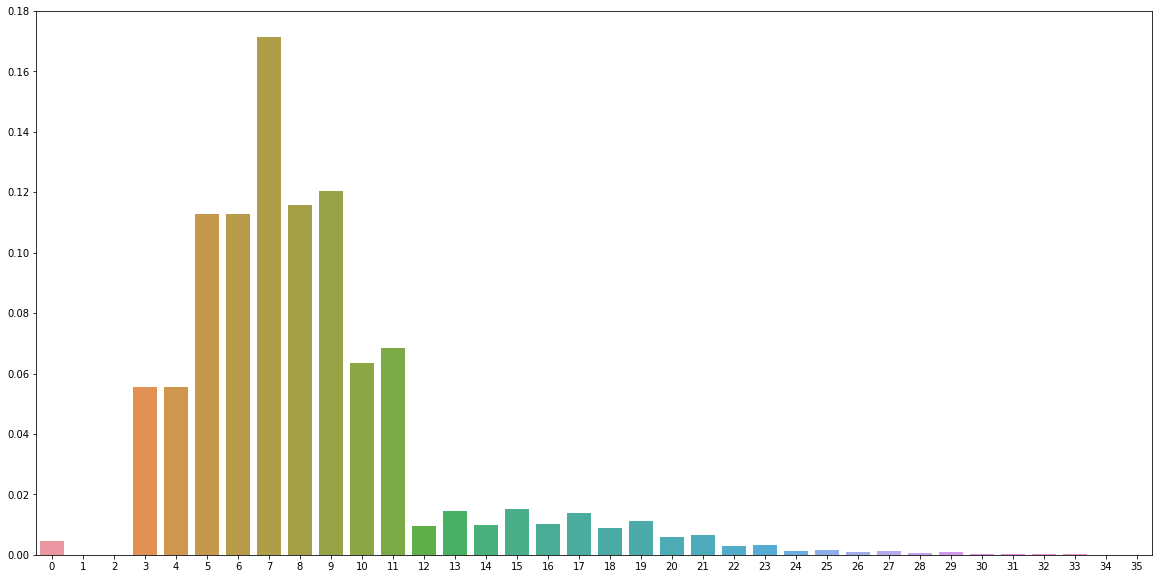

In [26]:
possible_rolls = [[1 for x in range(2 * speed_limit)] for x in range(die_sides ** (2 * speed_limit))]

i = 0
for possible_roll in possible_rolls:    
    for die in range(2 * speed_limit):
        possible_roll[die] += ((i // (die_sides ** (die_sides - (die + 1)))) % die_sides) 
    i += 1

advancement_probabilities = [0 for x in range(2 * speed_limit * die_sides)]
early_release_probability = 0
for possible_roll in possible_rolls:    
    roll_total = 0
    for roll in range(speed_limit):
        first_die = possible_roll[(2 * roll)]
        second_die = possible_roll[((2 * roll) + 1)]
        roll_total += first_die + second_die
        if (first_die != second_die):
            advancement_probabilities[int(roll_total)] += (1 / (die_sides ** (2 * speed_limit))) 
            break
        elif ((first_die == second_die) & (roll == (speed_limit - 1))):
            advancement_probabilities[0] += (1 / (die_sides ** (2 * speed_limit))) 

f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(y = advancement_probabilities, x = list(range(2 * speed_limit * die_sides)));            

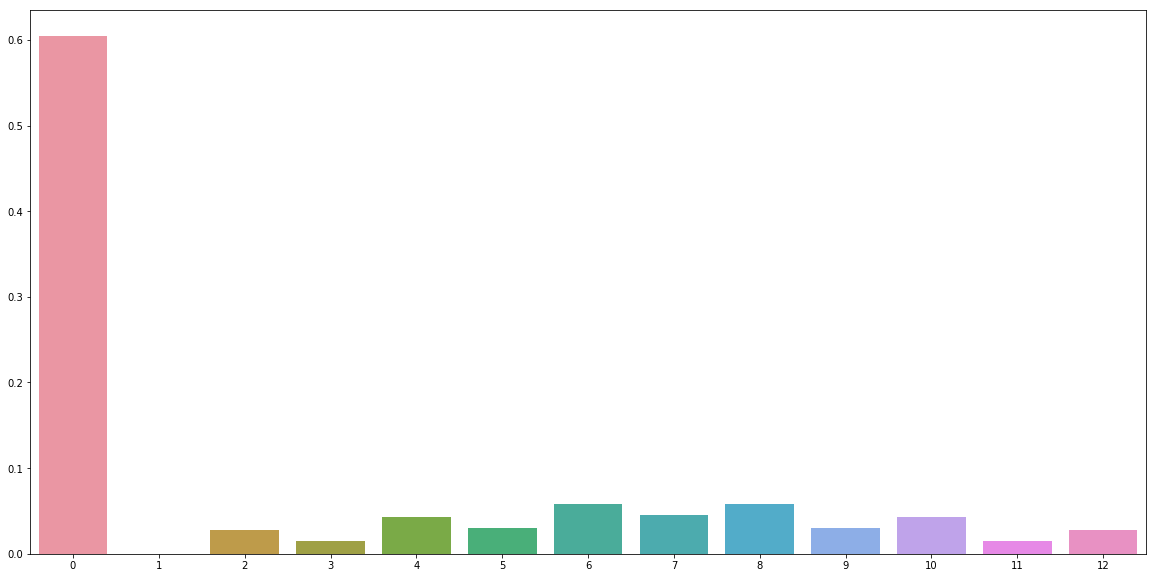

In [27]:
turns_in_jail = 0        
for turn in range(speed_limit):
    turns_in_jail += (((die_sides - 1) / die_sides) ** turn)   
                     
final_turn_in_jail = (((die_sides - 1) / die_sides) ** (speed_limit - 1)) / turns_in_jail   
    
advancement_probabilities_from_jail = [0 for x in range((2 * die_sides) + 1)]
advancement_probabilities_from_jail[0] = (1 - final_turn_in_jail) * ((die_sides - 1) / die_sides)
for space_from_jail in range((2 * die_sides) + 1):
    if (space_from_jail > 1):
        advancement_probabilities_from_jail[space_from_jail] +=  final_turn_in_jail * ((1 / die_sides) - (((((((die_sides + 1) - (space_from_jail)) > 0) * 2) - 1) * ((die_sides + 1) - (space_from_jail))) / die_sides**2)) 
        if ((space_from_jail % 2) == 0):
            advancement_probabilities_from_jail[space_from_jail] += ((1 - final_turn_in_jail) * (1 / (die_sides ** 2)))
            
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(y = advancement_probabilities_from_jail, x = list(range((2 * die_sides) + 1)));

In [29]:
transition_matrix_short_stay = [[0.0 for x in range(board_length)] for x in range(board_length)]
transition_matrix_long_stay = [[0.0 for x in range(board_length)] for x in range(board_length)]   
transition_matrix_short_stay[30][30] = advancement_probabilities[0]
transition_matrix_long_stay[30][30] = advancement_probabilities_from_jail[0] 

for current_property in range(board_length):
    if current_property != 30:
        transition_matrix_short_stay[current_property][30] += advancement_probabilities[0]
        transition_matrix_long_stay[current_property][30] += advancement_probabilities[0]
    for subsequent_property in range(2 * speed_limit * die_sides): 
        if current_property == 30:
            if (subsequent_property + 1) < (2 * speed_limit * die_sides):
                if (current_property + 1 + subsequent_property) >= board_length:
                    transition_matrix_short_stay[current_property][(10 + 1 + subsequent_property) % board_length] += advancement_probabilities[(subsequent_property + 1)]
                else:
                    transition_matrix_short_stay[current_property][(10 + 1 + subsequent_property)] += advancement_probabilities[(subsequent_property + 1)]
            if (subsequent_property + 1) < ((2 * die_sides) + 1):
                if (current_property + 1 + subsequent_property) >= board_length:
                    transition_matrix_long_stay[current_property][(10 + 1 + subsequent_property) % board_length] += advancement_probabilities_from_jail[(subsequent_property + 1)]
                else:    
                    transition_matrix_long_stay[current_property][(10 + 1 + subsequent_property)] += advancement_probabilities_from_jail[(subsequent_property + 1)]
        else:
            if (subsequent_property + 1) < (2 * speed_limit * die_sides):
                if (current_property + 1 + subsequent_property) >= board_length:
                    transition_matrix_short_stay[current_property][(current_property + 1 + subsequent_property) % board_length] += advancement_probabilities[(subsequent_property + 1)]
                    transition_matrix_long_stay[current_property][(current_property + 1 + subsequent_property) % board_length] += advancement_probabilities[(subsequent_property + 1)]                  
                else:
                    transition_matrix_short_stay[current_property][(current_property + 1 + subsequent_property)] += advancement_probabilities[(subsequent_property + 1)]
                    transition_matrix_long_stay[current_property][(current_property + 1 + subsequent_property)] += advancement_probabilities[(subsequent_property + 1)]

C:\Users\anees\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


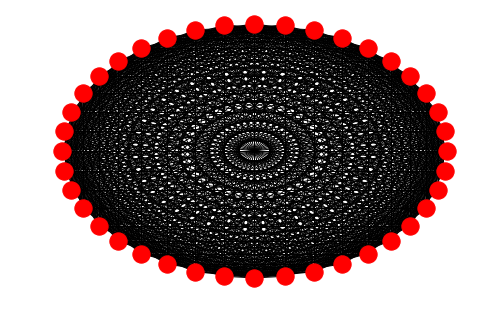

In [30]:
pre_chance_transition_matrix_short_stay = np.matrix(transition_matrix_short_stay)
network_pre_chance_short_stay = nx.from_numpy_matrix(pre_chance_transition_matrix_short_stay)
nx.draw_circular(network_pre_chance_short_stay)  
plt.draw()  

C:\Users\anees\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


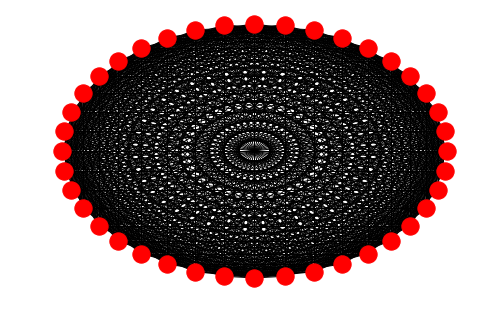

In [31]:
pre_chance_transition_matrix_long_stay = np.matrix(transition_matrix_long_stay)
network_pre_chance_long_stay = nx.from_numpy_matrix(pre_chance_transition_matrix_long_stay)
nx.draw_circular(network_pre_chance_long_stay)  
plt.draw() 

In [32]:
chance_spaces = [7, 22, 36]
community_chest_spaces = [2, 17, 33]
card_probability = (1/16)

for current_property in range(board_length):
    for chance_space in chance_spaces:
        #Advance to Go
        transition_matrix_short_stay[current_property][0] += (card_probability * transition_matrix_short_stay[current_property][chance_space])
        transition_matrix_long_stay[current_property][0] += (card_probability * transition_matrix_long_stay[current_property][chance_space])
        
        #Advance to Illinois Ave      
        transition_matrix_short_stay[current_property][24] += (card_probability * transition_matrix_short_stay[current_property][chance_space])
        transition_matrix_long_stay[current_property][24] += (card_probability * transition_matrix_long_stay[current_property][chance_space])
        
        #Advance to St Charles Pl
        transition_matrix_short_stay[current_property][11] += (card_probability * transition_matrix_short_stay[current_property][chance_space])
        transition_matrix_long_stay[current_property][11] += (card_probability * transition_matrix_long_stay[current_property][chance_space])
        
        #Advance to Boardwalk
        transition_matrix_short_stay[current_property][39] += (card_probability * transition_matrix_short_stay[current_property][chance_space])
        transition_matrix_long_stay[current_property][39] += (card_probability * transition_matrix_long_stay[current_property][chance_space])
        
        #Advance to Reading Railroad
        transition_matrix_short_stay[current_property][5] += (card_probability * transition_matrix_short_stay[current_property][chance_space])
        transition_matrix_long_stay[current_property][5] += (card_probability * transition_matrix_long_stay[current_property][chance_space])
        
        #Advance to the Nearest Railroad
        nearest_railroad = (10 * ((chance_space + 5)//10) + 5) % 40
        transition_matrix_short_stay[current_property][nearest_railroad] += (2 * card_probability * transition_matrix_short_stay[current_property][chance_space])
        transition_matrix_long_stay[current_property][nearest_railroad] += (2 * card_probability * transition_matrix_long_stay[current_property][chance_space])
        
        #Advance to the Nearest Utility
        nearest_utility = (40 - 12 * (2 * (((chance_space + 5)//20) % 2) - 1)) % 40
        transition_matrix_short_stay[current_property][nearest_utility] += (card_probability * transition_matrix_short_stay[current_property][chance_space])
        transition_matrix_long_stay[current_property][nearest_utility] += (card_probability * transition_matrix_long_stay[current_property][chance_space])
        
        #Go to Jail
        transition_matrix_short_stay[current_property][30] += (card_probability * transition_matrix_short_stay[current_property][chance_space])
        transition_matrix_long_stay[current_property][30] += (card_probability * transition_matrix_long_stay[current_property][chance_space])
        
        #Go Back 3 Spaces
        transition_matrix_short_stay[current_property][(chance_space - 3)] += (card_probability * transition_matrix_short_stay[current_property][chance_space])
        transition_matrix_long_stay[current_property][(chance_space - 3)] += (card_probability * transition_matrix_long_stay[current_property][chance_space])
        
        #Augment Chance Space Probabilities
        transition_matrix_short_stay[current_property][chance_space] -= (10 * card_probability * transition_matrix_short_stay[current_property][chance_space])    
        transition_matrix_long_stay[current_property][chance_space] -= (10 * card_probability * transition_matrix_long_stay[current_property][chance_space])        

    for community_chest_space in community_chest_spaces:
        #Advance to Go
        transition_matrix_short_stay[current_property][0] += (card_probability * transition_matrix_short_stay[current_property][community_chest_space])
        transition_matrix_long_stay[current_property][0] += (card_probability * transition_matrix_long_stay[current_property][community_chest_space])
        
        #Go to Jail
        transition_matrix_short_stay[current_property][30] += (card_probability * transition_matrix_short_stay[current_property][community_chest_space])
        transition_matrix_long_stay[current_property][30] += (card_probability * transition_matrix_long_stay[current_property][community_chest_space])
        
        #Augment Community Chest Space Probabilities
        transition_matrix_short_stay[current_property][community_chest_space] -= (2 * card_probability * transition_matrix_short_stay[current_property][community_chest_space])
        transition_matrix_long_stay[current_property][community_chest_space] -= (2 * card_probability * transition_matrix_long_stay[current_property][community_chest_space])     

C:\Users\anees\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


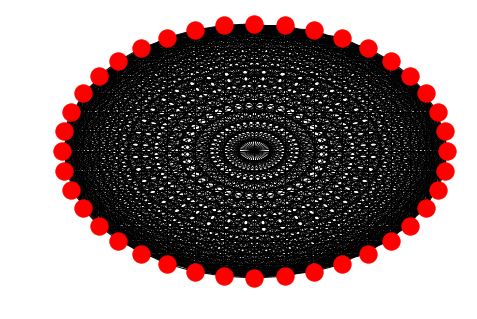

In [33]:
transition_matrix_short_stay = np.matrix(transition_matrix_short_stay)
network_short_stay = nx.from_numpy_matrix(transition_matrix_short_stay)
nx.draw_circular(network_short_stay)  
plt.draw()  

C:\Users\anees\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


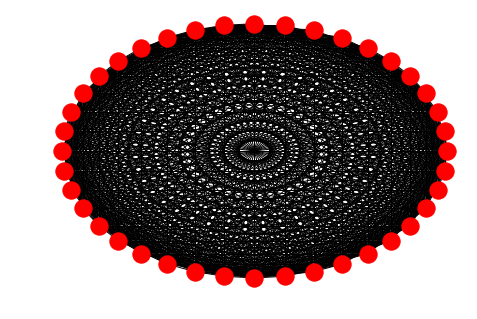

In [34]:
transition_matrix_long_stay = np.matrix(transition_matrix_long_stay)
network_long_stay = nx.from_numpy_matrix(transition_matrix_long_stay)
nx.draw_circular(network_long_stay)  
plt.draw() 

In [36]:
def steady_state_probabilities(transition_state):
    dimensions = transition_state.shape[0]
    q = (transition_state-np.eye(dimensions))
    ones = np.ones(dimensions)
    q = np.c_[q,ones]
    QTQ = np.dot(q, q.T)
    bQT = np.ones(dimensions)
    return np.linalg.solve(QTQ,bQT)

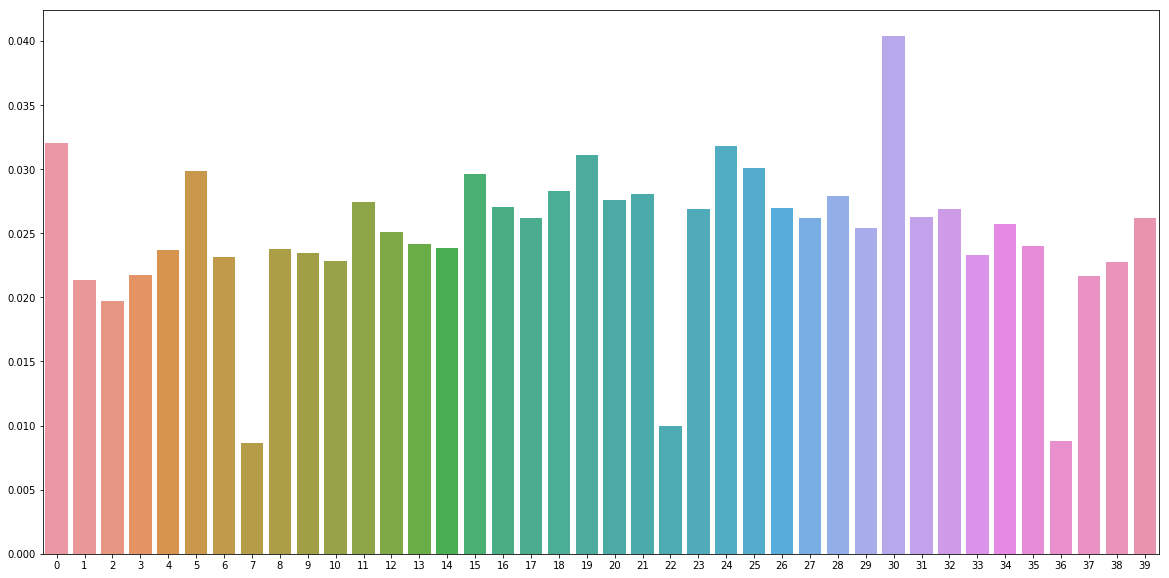

In [79]:
steady_state_matrix_short_stay = steady_state_probabilities(transition_matrix_short_stay)

f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(y = steady_state_matrix_short_stay, x = list(range(board_length)));     

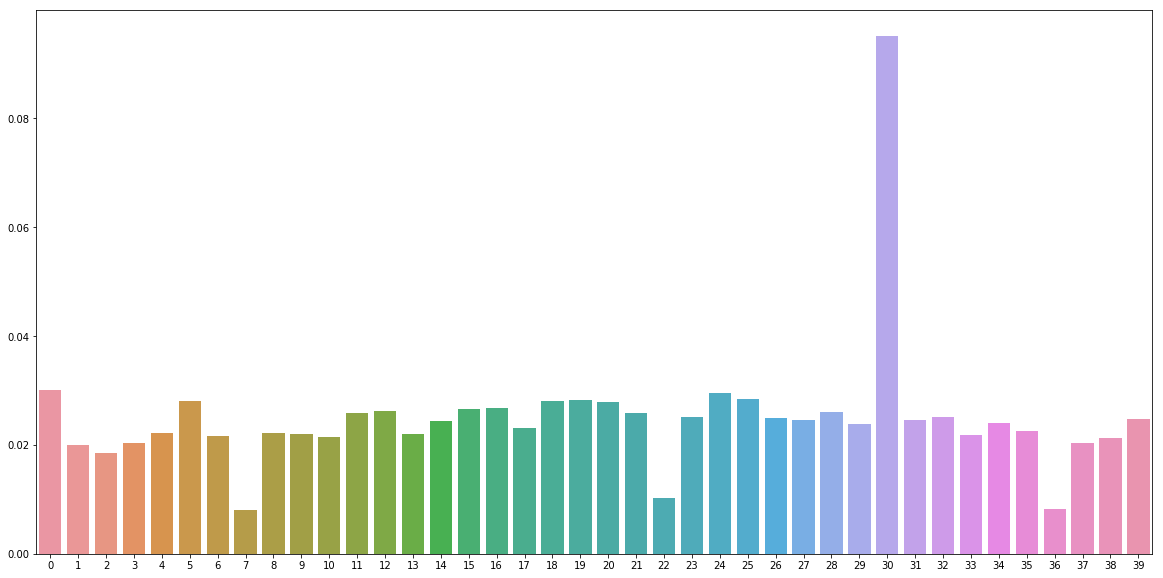

In [38]:
steady_state_matrix_long_stay = steady_state_probabilities(transition_matrix_long_stay)

f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(y = steady_state_matrix_long_stay, x = list(range(board_length)));     

In [83]:
data_wd = "C:\\Users\\anees\\Desktop\\UVA MSDS 2020\\Fall Session\\DS 6014\\Project"
os.chdir(data_wd)

property_data = pd.read_csv("property_data.csv")
property_data

,Index,Space Name,Suite,Lot Price,Unimproved Rent,Marginal Improvement Cost,Improved State 1 Rent,Improved State 1 Cost,Improved State 2 Rent,Improved State 2 Cost,Improved State 3 Rent,Improved State 3 Cost,Improved State 4 Rent,Improved State 4 Cost,Improved State 5 Rent,Improved State 5 Cost
0,0,Go,Neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Mediterranean Ave.,Navy Blue,60.0,2.00,50.0,10.00,170.0,30.0,270.0,90.0,370.0,160.0,470.0,250.0,570.0
2,2,Community Chest,Neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Baltic Ave.,Navy Blue,60.0,4.00,50.0,20.00,170.0,60.0,270.0,180.0,370.0,320.0,470.0,450.0,570.0
4,4,Income Tax,Neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,Reading Railroad,Railroad,200.0,25.00,200.0,50.00,400.0,100.0,600.0,200.0,800.0,NaN,NaN,NaN,NaN
6,6,Oriental Ave.,Sky Blue,100.0,6.00,50.0,30.00,370.0,90.0,520.0,270.0,670.0,400.0,820.0,550.0,970.0
7,7,Chance,Neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,Vermont Ave.,Sky Blue,100.0,6.00,50.0,30.00,370.0,90.0,520.0,270.0,670.0,400.0,820.0,550.0,970.0
9,9,Connecticut Avenue,Sky Blue,120.0,8.00,50.0,40.00,370.0,100.0,520.0,300.0,670.0,450.0,820.0,600.0,970.0


In [ ]:

property_data["Short Jail Stay Visitation Probability"] = steady_state_matrix_short_stay
property_data["Short Jail Stay Expected Unimproved Rent"] = property_data["Short Jail Stay Visitation Probability"] * property_data["Unimproved Rent"]
property_data["Short Jail Stay Unimproved Return on Investment"] = property_data["Lot Price"] / property_data["Short Jail Stay Expected Unimproved Rent"]

property_data["Short Jail Stay Expected Improved State 1 Rent"] = property_data["Short Jail Stay Visitation Probability"] * property_data["Improved State 1 Rent"]
property_data["Short Jail Stay Improved State 1 Return on Investment"] = property_data["Improved State 1 Cost"] / property_data["Short Jail Stay Expected Improved State 1 Rent"]

property_data["Short Jail Stay Expected Improved State 2 Rent"] = property_data["Short Jail Stay Visitation Probability"] * property_data["Improved State 2 Rent"]
property_data["Short Jail Stay Improved State 2 Return on Investment"] = property_data["Improved State 2 Cost"] / property_data["Short Jail Stay Expected Improved State 2 Rent"]

property_data["Short Jail Stay Expected Improved State 3 Rent"] = property_data["Short Jail Stay Visitation Probability"] * property_data["Improved State 3 Rent"]
property_data["Short Jail Stay Improved State 3 Return on Investment"] = property_data["Improved State 3 Cost"] / property_data["Short Jail Stay Expected Improved State 3 Rent"]

property_data["Short Jail Stay Expected Improved State 4 Rent"] = property_data["Short Jail Stay Visitation Probability"] * property_data["Improved State 4 Rent"]
property_data["Short Jail Stay Improved State 4 Return on Investment"] = property_data["Improved State 4 Cost"] / property_data["Short Jail Stay Expected Improved State 4 Rent"]

property_data["Short Jail Stay Expected Improved State 5 Rent"] = property_data["Short Jail Stay Visitation Probability"] * property_data["Improved State 5 Rent"]
property_data["Short Jail Stay Improved State 5 Return on Investment"] = property_data["Improved State 5 Cost"] / property_data["Short Jail Stay Expected Improved State 5 Rent"]

#property_data["Short Jail Stay Expected Final Improved State Rent"] = property_data["Short Jail Stay Visitation Probability"] * property_data["Final Improved State Rent"]
#property_data["Short Jail Stay Final Improved State Return on Investment"] = property_data["Final Improved State Cost"] / property_data["Short Jail Stay Expected Final Improved State Rent"]

property_data["Long Jail Stay Visitation Probability"] = steady_state_matrix_long_stay
property_data["Long Jail Stay Expected Unimproved Rent"] = property_data["Long Jail Stay Visitation Probability"] * property_data["Unimproved Rent"]
property_data["Long Jail Stay Unimproved Return on Investment"] = property_data["Lot Price"] / property_data["Long Jail Stay Expected Unimproved Rent"]

property_data["Long Jail Stay Expected Improved State 1 Rent"] = property_data["Long Jail Stay Visitation Probability"] * property_data["Improved State 1 Rent"]
property_data["Long Jail Stay Improved State 1 Return on Investment"] = property_data["Improved State 1 Cost"] / property_data["Long Jail Stay Expected Improved State 1 Rent"]

property_data["Long Jail Stay Expected Improved State 2 Rent"] = property_data["Long Jail Stay Visitation Probability"] * property_data["Improved State 2 Rent"]
property_data["Long Jail Stay Improved State 2 Return on Investment"] = property_data["Improved State 2 Cost"] / property_data["Long Jail Stay Expected Improved State 2 Rent"]

property_data["Long Jail Stay Expected Improved State 3 Rent"] = property_data["Long Jail Stay Visitation Probability"] * property_data["Improved State 3 Rent"]
property_data["Long Jail Stay Improved State 3 Return on Investment"] = property_data["Improved State 3 Cost"] / property_data["Long Jail Stay Expected Improved State 3 Rent"]

property_data["Long Jail Stay Expected Improved State 4 Rent"] = property_data["Long Jail Stay Visitation Probability"] * property_data["Improved State 4 Rent"]
property_data["Long Jail Stay Improved State 4 Return on Investment"] = property_data["Improved State 4 Cost"] / property_data["Long Jail Stay Expected Improved State 4 Rent"]

property_data["Long Jail Stay Expected Improved State 5 Rent"] = property_data["Long Jail Stay Visitation Probability"] * property_data["Improved State 5 Rent"]
property_data["Long Jail Stay Improved State 5 Return on Investment"] = property_data["Improved State 5 Cost"] / property_data["Long Jail Stay Expected Improved State 5 Rent"]

#property_data["Long Jail Stay Expected Final Improved State Rent"] = property_data["Long Jail Stay Visitation Probability"] * property_data["Final Improved State Rent"]
#property_data["Long Jail Stay Final Improved State Return on Investment"] = property_data["Final Improved State Cost"] / property_data["Long Jail Stay Expected Final Improved State Rent"]


Property	Shortest Stay in Jail	Longest Stay in Jail
Go						0.03203130509985983	0.030019748658837653
Mediterranean Avenue	0.02133491527275759	0.019966643295983452
Community Chest			0.019691389413832406	0.018432456930422267
Baltic Avenue			0.021740147510827038	0.020357151367570114
Income Tax				0.023727063057982223	0.02222645766739207
Reading Railroad		0.029857194013680557	0.028121941040823713
Oriental Avenue			0.023126316116279206	0.021676835571224733
Chance					0.008679304037600174	0.008133876193751126
Vermont Avenue			0.023771067173511715	0.022284289319112742
Connecticut Avenue		0.023492572381918146	0.02201847252377055
Just Visiting Jail		0.02284289251771107	0.0214194337290831
St. Charles Place		0.027400198820233646	0.025835843121945826
Electric Company		0.02508702251252308	0.026168114212501124
States Avenue			0.024185426403458415	0.02202854848459034
Virginia Avenue			0.02384623156588369	0.02436449579769806
Pennsylvania Railroad	0.029650679544060716	0.026594564207727756
St. James Pla

C:\Users\anees\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


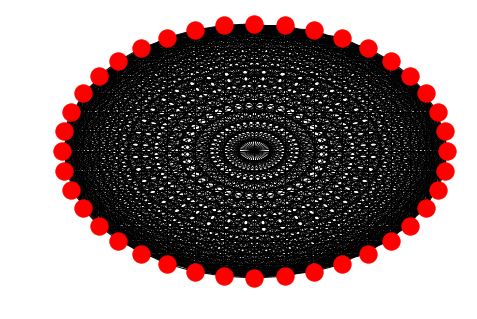

In [44]:
print("Property" + "\t" + "Shortest Stay in Jail" + "\t" + "Longest Stay in Jail")
for state in range(board_length):
    print(list_of_properties[state] + str(steady_state_matrix_short_stay[state]) + '\t' + str(steady_state_matrix_long_stay[state]))
    
network_short_stay = nx.from_numpy_matrix(transition_matrix_short_stay)
nx.draw_circular(network_short_stay)  
plt.draw()  
network_long_stay = nx.from_numpy_matrix(transition_matrix_long_stay)
